# Проект по Методи и софтуер за машинно обучение
Студент: Кристиян Кръчмаров <br>
Фак. номер: 791324005 <br>


## Зареждане на данните

In [1]:
import pandas as pd

path = "../Data/"
data = pd.read_csv(path + "shuffle_email_spam_classification.csv")
data.info()
print("\nNaN in data: {}".format(data.isna().any().any()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Columns: 3002 entries, Email No. to Prediction
dtypes: int64(3001), object(1)
memory usage: 118.5+ MB

NaN in data: False


In [2]:
data = data.iloc[:, 1:]  # remove 'Email No' column

X = data.iloc[:, :-1]  # explanatory variables
Y = data.iloc[:, -1]  # result

print(X.shape)
print(Y.shape)

(5172, 3000)
(5172,)


## Helpers
Няколко helper метода <br>

In [3]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import clone

def get_metrics(classifier, x_train, y_train, x_test, y_test):
    """Train a classifier and get different metrics"""

    classifier = clone(classifier)  # get unfitted classifier
    classifier.fit(x_train, y_train)  # train

    predicted = classifier.predict(x_test)  # get prediction
    probabilities = classifier.predict_proba(x_test)  # get probabilities of each class
    probabilities = probabilities[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, probabilities)  # ROC curve
    auc = roc_auc_score(y_test, probabilities)  # AUC score

    conf_matrix = confusion_matrix(y_test, predicted)  # confusion matrix

    accuracy = classification_report(y_test, predicted, output_dict=True)['accuracy']  # accuracy
    cl_report = classification_report(y_test, predicted, output_dict=False)  # classification report

    return {
        "ACC": accuracy,
        "AUC": auc,
        "TPR": tpr,
        "FPR": fpr,
        "Threshold": threshold,
        "ConfusionMatrix": conf_matrix,
        "ClassificationReport": cl_report,
    }

In [4]:
import matplotlib.pyplot as plt

def get_metrics_train_and_test(classifier, x_train, y_train, x_test, y_test, plot_roc_curve=False):
    """
    Get metrics for a classifier when training and test data are the same and also train and test data are different.
    Plot the ROC curve.
    Return the metrics for each training scenario
    """
    train_train = get_metrics(classifier, x_train, y_train, x_train, y_train)
    train_test = get_metrics(classifier, x_train, y_train, x_test, y_test)

    # Plot setup
    if plot_roc_curve:
        fg, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].set_xlim([-0.05, 1.05])
        axes[0].set_ylim([-0.05, 1.05])
        axes[0].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[0].set_title("ROC (Test set)")
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")

        axes[1].set_xlim([-0.05, 1.05])
        axes[1].set_ylim([-0.05, 1.05])
        axes[1].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[1].set_title("ROC (Training set)")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")

        axes[0].plot(train_test["FPR"], train_test["TPR"], marker="", color="green", alpha=0.6)
        axes[1].plot(train_train["FPR"], train_train["TPR"], marker="", color="red", alpha=0.6)

        plt.show()

    return {
        "train-train": train_train,
        "train-test": train_test,
    }

За метода `k_fold_cross_validation` използваме `KFold` който разделя данните

In [5]:
from sklearn.model_selection import KFold

def k_fold_cross_validation_classifier(classifier, X: pd.DataFrame, Y: pd.DataFrame, splits=10, plot_roc_curve=False):
    """
    Perform k-fold cross validation for classifier.
    Plot the ROC curve for each fold.
    Return performance metrics for each fold.
    """

    kf = KFold(n_splits=splits, shuffle=True)

    df_columns = ["Fold", "ACC Test", "ACC Training", "ACC ratio", "AUC Test", "AUC Training", "AUC ratio", "CONF_MTX"]
    performance_df = pd.DataFrame(columns=df_columns)

    # plot setup
    if plot_roc_curve:
        fg, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].set_xlim([-0.05, 1.05])
        axes[0].set_ylim([-0.05, 1.05])
        axes[0].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[0].title.set_text("k-Fold ROC (Test set)")
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")

        axes[1].set_xlim([-0.05, 1.05])
        axes[1].set_ylim([-0.05, 1.05])
        axes[1].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[1].title.set_text("k-Fold ROC (Training set)")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")

    i = 0
    #k-fold
    for trainIndex, testIndex in kf.split(X, Y):
        print(f"Processing fold {i + 1}...")
        X_train, X_test = X.iloc[trainIndex], X.iloc[testIndex]
        Y_train, Y_test = Y.iloc[trainIndex], Y.iloc[testIndex]

        metrics_train_train = get_metrics(classifier, X_train, Y_train, X_train, Y_train)
        metrics_train_test = get_metrics(classifier, X_train, Y_train, X_test, Y_test)

        if plot_roc_curve:
            axes[0].plot(metrics_train_test["FPR"], metrics_train_test["TPR"], marker="", color="blue", alpha=0.6)
            axes[1].plot(metrics_train_train["FPR"], metrics_train_train["TPR"], marker="", color="orange", alpha=0.6)

        temp = {'Fold': i,
                'ACC Test': metrics_train_test["ACC"],
                'ACC Training': metrics_train_train["ACC"],
                'ACC ratio': metrics_train_test["ACC"] / metrics_train_train["ACC"],
                'AUC Test': metrics_train_test["AUC"],
                'AUC Training': metrics_train_train["AUC"],
                'AUC ratio': metrics_train_test["AUC"] / metrics_train_train["AUC"],
                'CONF_MTX': metrics_train_test["ConfusionMatrix"]}

        temp_df = pd.DataFrame([temp])
        performance_df = pd.concat([performance_df, temp_df], ignore_index=True)
        i = i + 1

    if plot_roc_curve:
        plt.show()

    return performance_df

In [6]:
def print_metrics(metrics_train_and_test):
    """Print metrics for differently trained classifier"""
    train_train = metrics_train_and_test.get('train-train', 'not-found')
    train_test = metrics_train_and_test.get('train-test', 'not-found')

    print("Train-Train ACC: {}".format(train_train.get('ACC', 'not-found')))
    print("Train-Test ACC: {}".format(train_test.get('ACC', 'not-found')))
    print("\n")
    print("Train-Train AUC: {}".format(train_train.get('AUC', 'not-found')))
    print("Train-Test AUC: {}".format(train_test.get('AUC', 'not-found')))
    print("\n")
    print("Train-Train Confusion Matrix: \n {}".format(train_train.get('ConfusionMatrix', 'not-found')))
    print("\n")
    print("Train-Test Confusion Matrix: \n {}".format(train_test.get('ConfusionMatrix', 'not-found')))
    print("\n")
    # print("Train-Train Classification report: \n {}".format(train_train.get('ClassificationReport', 'not-found')))
    # print("\n")
    # print("Train-Test Classification report: \n {}".format(train_test.get('ClassificationReport', 'not-found')))

In [31]:
def plot_history_nn(nn):
    """Plots graphs for accuracy and loss for the duration of the training of the Neural Network"""
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(nn.history['accuracy'], color='blue')
    ax[0].plot(nn.history['val_accuracy'], color='green')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(['Train', 'Validate'])
    ax[0].axis(ymin=0.5, ymax=1.1)
    ax[0].margins(0.03)

    ax[1].plot(nn.history['loss'], color='blue')
    ax[1].plot(nn.history['val_loss'], color='red')
    ax[1].set_title('Model loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['Train', 'Validate'])
    ax[1].margins(0.03)

    plt.show()

## 1. Logistic regression
Първо ще обучим един класификатор `LogisticRegression` без preprocessing, за да видим как се справя

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


D:\Python venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Python venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

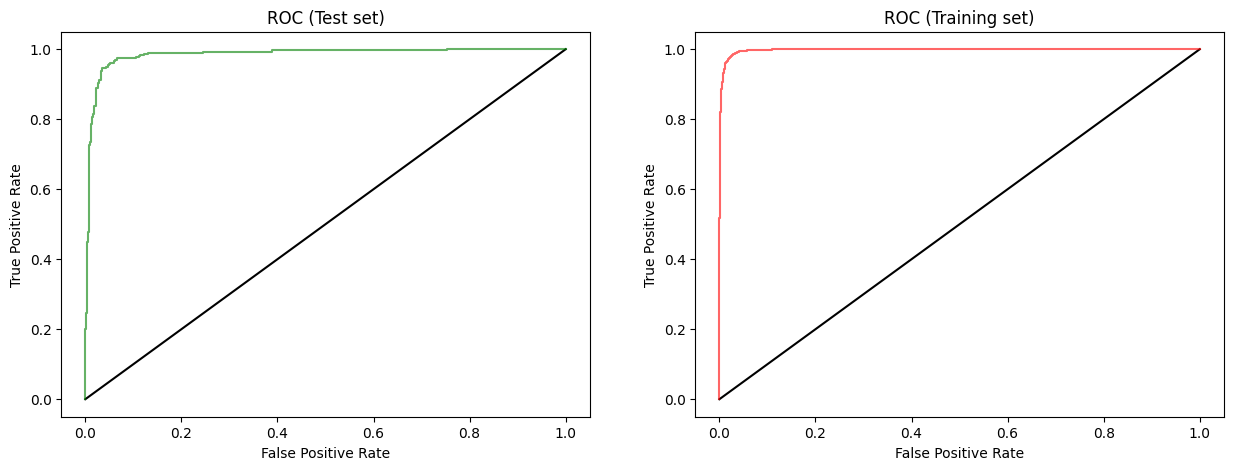

In [9]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()

lr_metrics_train_and_test = get_metrics_train_and_test(logistic_regression, X_train, Y_train, X_test, Y_test,
                                                       plot_roc_curve=True)

Проверяваме модела чрез k_fold cross валидация

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...


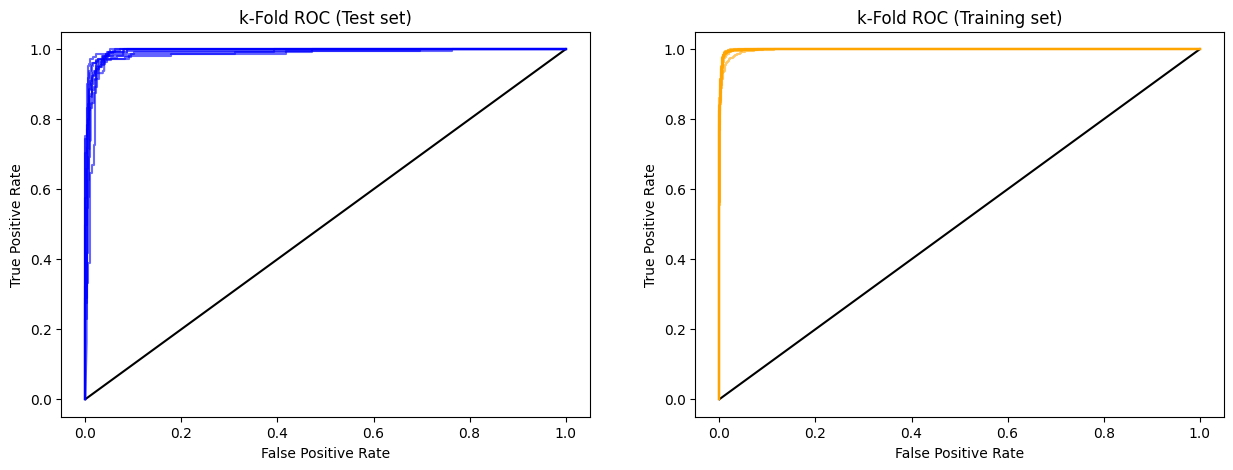

In [10]:
import warnings  # to not log the same warning on every iteration

warnings.filterwarnings('ignore')
lr_k_fold = k_fold_cross_validation_classifier(logistic_regression, X, Y, plot_roc_curve=True)
warnings.filterwarnings('default')

In [11]:
print_metrics(lr_metrics_train_and_test)

Train-Train ACC: 0.9784868262025622
Train-Test ACC: 0.9584541062801932


Train-Train AUC: 0.9978014764803165
Train-Test AUC: 0.9848464354632184


Train-Train Confusion Matrix: 
 [[2888   52]
 [  37 1160]]


Train-Test Confusion Matrix: 
 [[705  27]
 [ 16 287]]




Сега ще приложим някакъв вид preprocessing, за да видим дали ще има промяна <br>
В случая съм използвал `MinMaxScaler` чрез който всичките ни данни ще са в диапазона $[0,1]$.

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


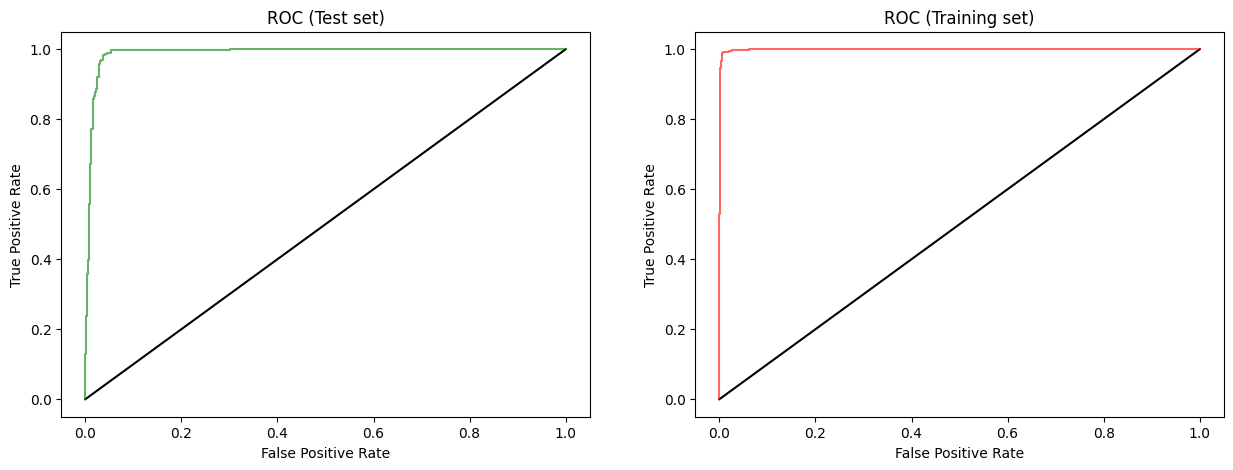

In [13]:
logistic_regression = LogisticRegression()
lr_metrics_train_and_test = get_metrics_train_and_test(logistic_regression, X_train, Y_train, X_test, Y_test,
                                                       plot_roc_curve=True)

Processing fold 1...


C:\Users\krist\AppData\Local\Temp\ipykernel_7992\2993316972.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, temp_df], ignore_index=True)


Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...


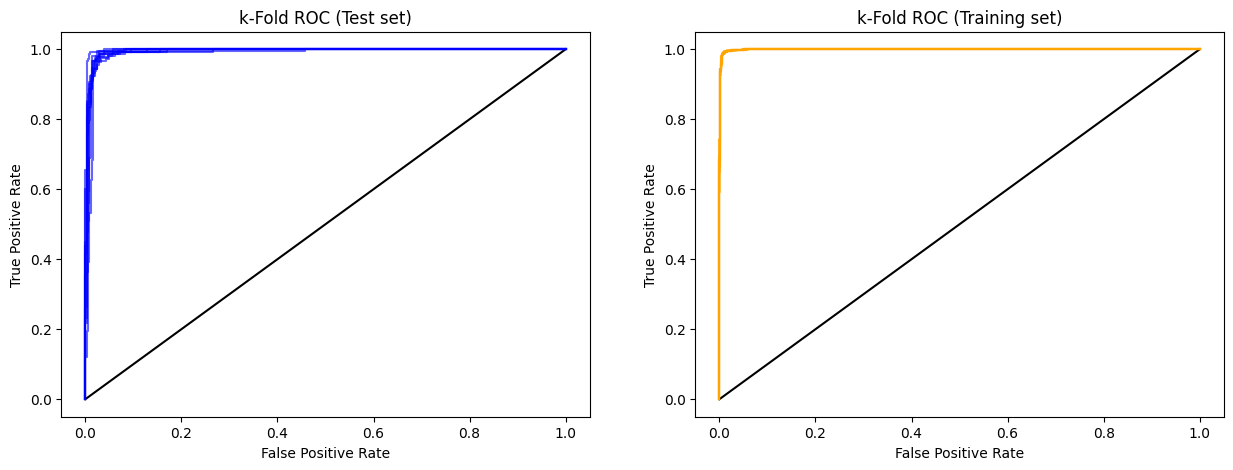

In [14]:
lr_k_fold = k_fold_cross_validation_classifier(logistic_regression, X_scaled, Y, plot_roc_curve=True)
# lr_k_fold.head(10)

In [15]:
print_metrics(lr_metrics_train_and_test)

Train-Train ACC: 0.9857384578196761
Train-Test ACC: 0.9516908212560387


Train-Train AUC: 0.9993051202239159
Train-Test AUC: 0.9893680927939785


Train-Train Confusion Matrix: 
 [[2943    8]
 [  51 1135]]


Train-Test Confusion Matrix: 
 [[703  18]
 [ 32 282]]




Точността $ACC$ се повиши от Train-Test $ACC \approx 0.96$ на Train-Test $ACC \approx 0.98$, което е подобрение. <br>
Не се наблюдава underfitting или overfitting

## 2. Random forest
Ще обучим един `RandomForestClassifier` без preprocessing на данните за да видим как ще се справи

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


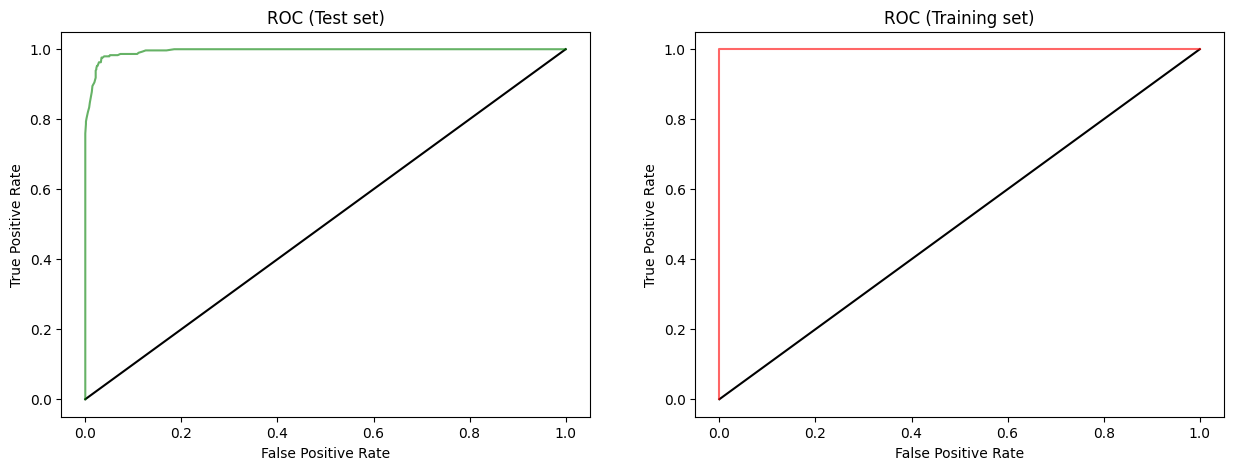

In [17]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

rf_metrics_train_and_test = get_metrics_train_and_test(random_forest, X_train, Y_train, X_test, Y_test,
                                                       plot_roc_curve=True)

Processing fold 1...


C:\Users\krist\AppData\Local\Temp\ipykernel_7992\2993316972.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, temp_df], ignore_index=True)


Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...


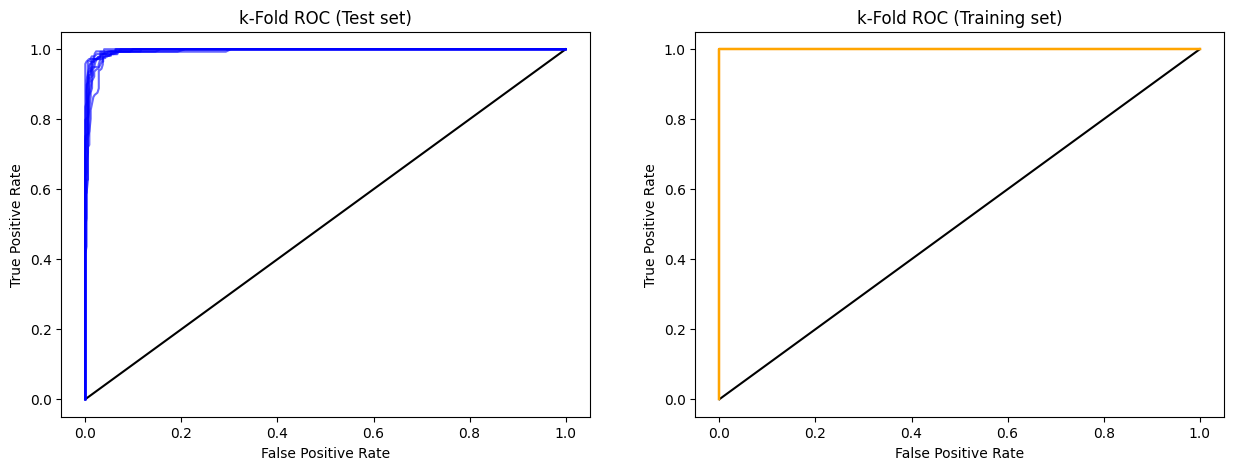

In [18]:
rf_k_fold = k_fold_cross_validation_classifier(random_forest, X, Y, plot_roc_curve=True)
# rf_k_fold.head(10)

In [19]:
print_metrics(rf_metrics_train_and_test)

Train-Train ACC: 1.0
Train-Test ACC: 0.9681159420289855


Train-Train AUC: 1.0
Train-Test AUC: 0.9948442510306917


Train-Train Confusion Matrix: 
 [[2932    0]
 [   0 1205]]


Train-Test Confusion Matrix: 
 [[723  17]
 [ 16 279]]




Модела се справя добре с данните на които е обучен, както и тестовите данни. <br>
Да видим дали с някакъв вид preprocessing ще има промяна. За целта ще се използва отново `MinMaxScaller`.

In [20]:
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


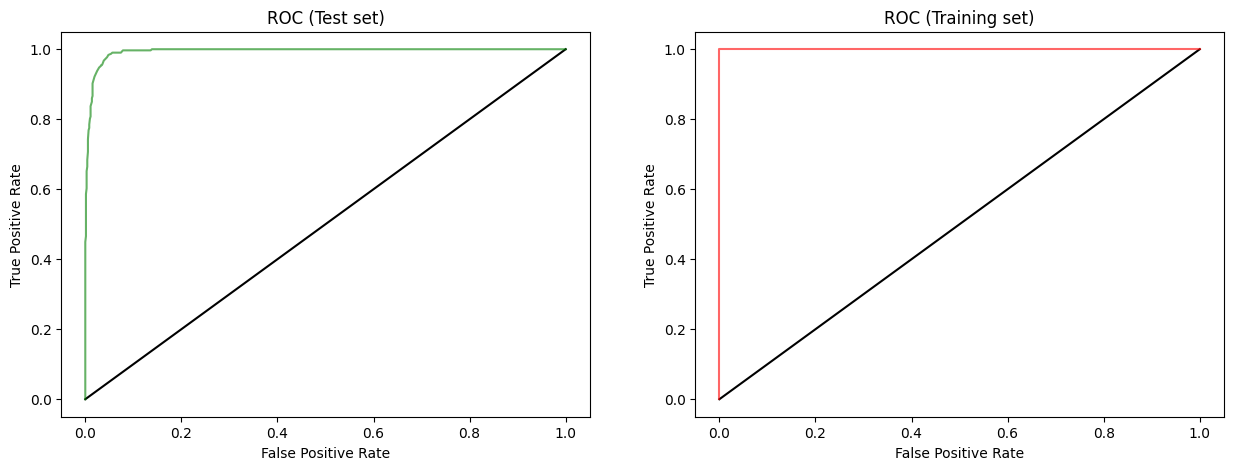

In [21]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, Y_train)
rf_metrics_train_and_test = get_metrics_train_and_test(random_forest, X_train, Y_train, X_test, Y_test,
                                                       plot_roc_curve=True)

Processing fold 1...


C:\Users\krist\AppData\Local\Temp\ipykernel_7992\2993316972.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, temp_df], ignore_index=True)


Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...


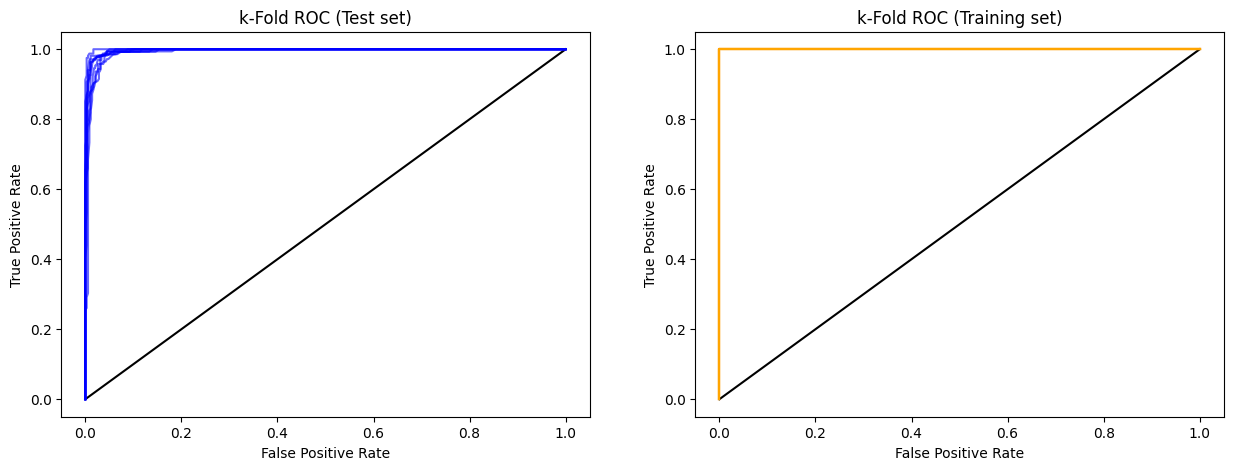

In [22]:
rf_k_fold = k_fold_cross_validation_classifier(random_forest, X_scaled, Y, plot_roc_curve=True)

In [23]:
print_metrics(rf_metrics_train_and_test)

Train-Train ACC: 1.0
Train-Test ACC: 0.9632850241545894


Train-Train AUC: 1.0
Train-Test AUC: 0.9938298672012027


Train-Train Confusion Matrix: 
 [[2944    0]
 [   0 1193]]


Train-Test Confusion Matrix: 
 [[714  14]
 [ 24 283]]




Има пренебрежително подобрение за точността: от $ACC = 0.975$ на $ACC = 0.978$. <br>
Следователно preprocessing-a не е необходим. <br>
Няма наличиние на underfiting или overfitting.

## 3. Neural network
Ще се наложи използването на `MinMaxScaller`, тъй като невронните мрежи за чуствителни към мащаба на данните

In [24]:
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


За първата мрежа ще използваме следната структура за слоевете:
1. 32 неврона с активационна функция relu
2. 16 неврона с активационна функция relu
3. 1 резултатен с активационна функция sigmoid

С `layers.Input` се задават броя на началните параметри. <br>
За `optimizer` ще използваме `adam`, a за `loss` - `binary_crossentropy`

In [25]:
from keras import models, layers

NUMBER_INPUTS = X_train.shape[1]
print(NUMBER_INPUTS)

network_layers = [
    layers.Input(shape=(NUMBER_INPUTS,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
]

neural_network = models.Sequential(network_layers)

neural_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

neural_network.summary()

3000


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        96,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,577 (377.25 KB)

 Trainable params: 96,577 (377.25 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = neural_network.fit(X_train, Y_train, epochs=50, batch_size=64, validation_split=0.1)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7198 - loss: 0.5857 - val_accuracy: 0.8406 - val_loss: 0.3215
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9110 - loss: 0.2609 - val_accuracy: 0.9396 - val_loss: 0.1745
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9710 - loss: 0.1248 - val_accuracy: 0.9686 - val_loss: 0.1096
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0720 - val_accuracy: 0.9807 - val_loss: 0.0787
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0473 - val_accuracy: 0.9758 - val_loss: 0.0664
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0320 - val_accuracy: 0.9783 - val_loss: 0.0597
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0289 - val_accuracy: 0.9758 - val_loss: 0.0579
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0199 - val_accuracy: 0.9734 - val_loss:

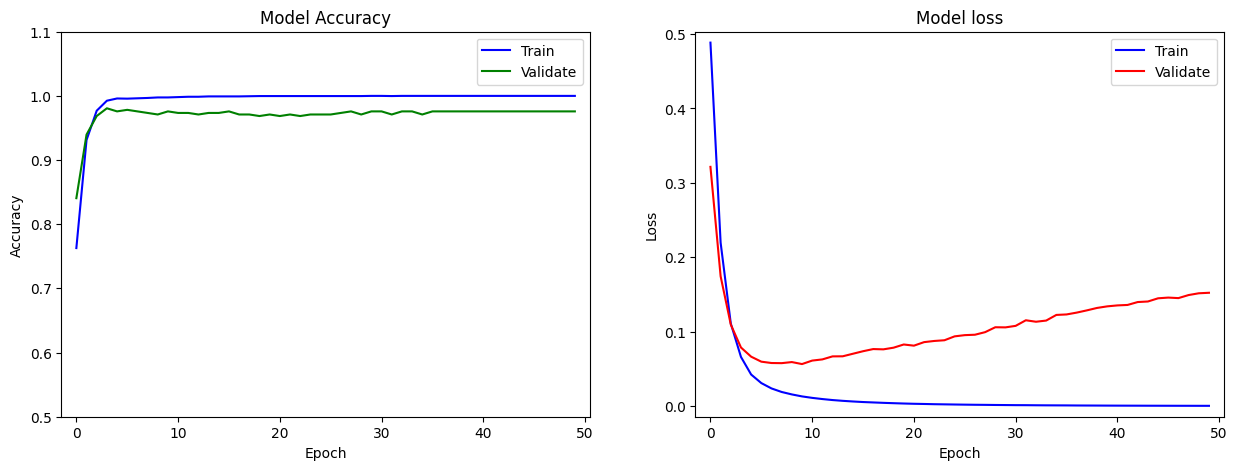

In [33]:
plot_history_nn(history)

Невронната мрежа започва да overfit-ва oколо 5тата епоха на обучение, защото loss функцията за валидационнитте данни започва да расте. Точността спира да се увеличава. <br>
За да подобрим резултата ще добавим още 2 слоя и ще намалим броя епохи на обучение

In [28]:
from keras import regularizers

network_layers2 = [
    layers.Input(shape=(NUMBER_INPUTS,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
]

neural_network2 = models.Sequential(network_layers2)
neural_network2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

neural_network2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       384,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,009 (1.51 MB)

 Trainable params: 395,009 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history2 = neural_network2.fit(X_train, Y_train, epochs=30, batch_size=64, validation_split=0.1)

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7629 - loss: 0.5374 - val_accuracy: 0.9831 - val_loss: 0.1060
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9853 - loss: 0.0658 - val_accuracy: 0.9831 - val_loss: 0.0469
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - loss: 0.0280 - val_accuracy: 0.9855 - val_loss: 0.0363
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0125 - val_accuracy: 0.9879 - val_loss: 0.0423
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0076 - val_accuracy: 0.9855 - val_loss: 0.0440
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0048 - val_accuracy: 0.9855 - val_loss: 0.0411
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0043 - val_accuracy: 0.9879 - val_loss: 0.0441
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0019 - val_accuracy: 0.9783 - val_loss:

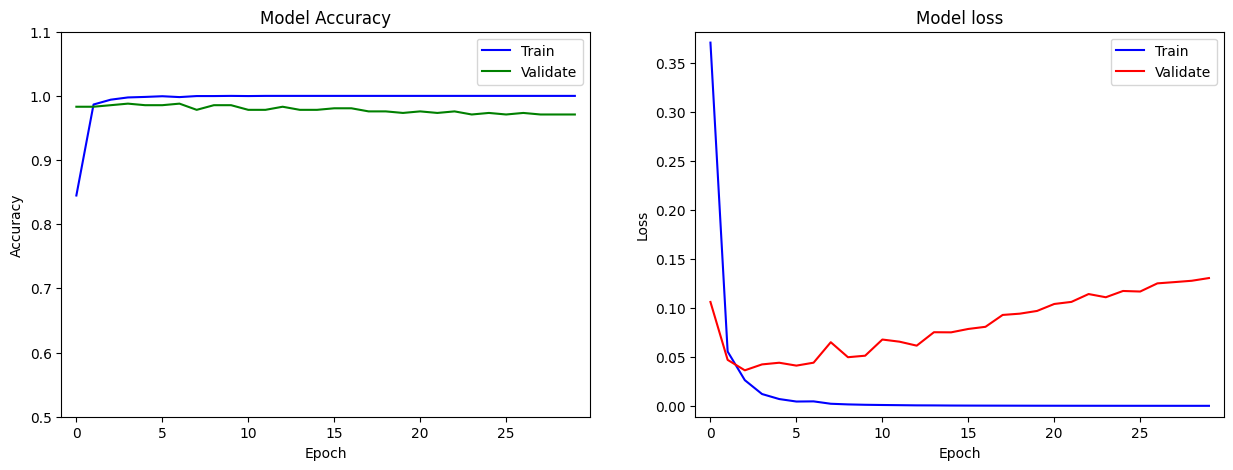

In [32]:
plot_history_nn(history2)

Има наличие на overfitting, защото отново loss функцията за валидационните данни расте и е по голяма от тази за обучителните данни. <br>
За да решим този проблем ще добавим регуляризация.

In [34]:
network_layers3 = [
    layers.Input(shape=(NUMBER_INPUTS,)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
]

neural_network3 = models.Sequential(network_layers3)

neural_network3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

neural_network3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │       384,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,009 (1.51 MB)

 Trainable params: 395,009 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history3 = neural_network3.fit(X_train, Y_train, epochs=30, batch_size=64, validation_split=0.1)

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6687 - loss: 3.0550 - val_accuracy: 0.7246 - val_loss: 1.1649
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7599 - loss: 1.0350 - val_accuracy: 0.9348 - val_loss: 0.6855
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9390 - loss: 0.6533 - val_accuracy: 0.9251 - val_loss: 0.5410
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9558 - loss: 0.4993 - val_accuracy: 0.9783 - val_loss: 0.4190
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9670 - loss: 0.4221 - val_accuracy: 0.9638 - val_loss: 0.3799
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9682 - loss: 0.3791 - val_accuracy: 0.9517 - val_loss: 0.3914
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9684 - loss: 0.3682 - val_accuracy: 0.9614 - val_loss: 0.3786
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9734 - loss: 0.3688 - val_accuracy: 0.9565 - val_loss:

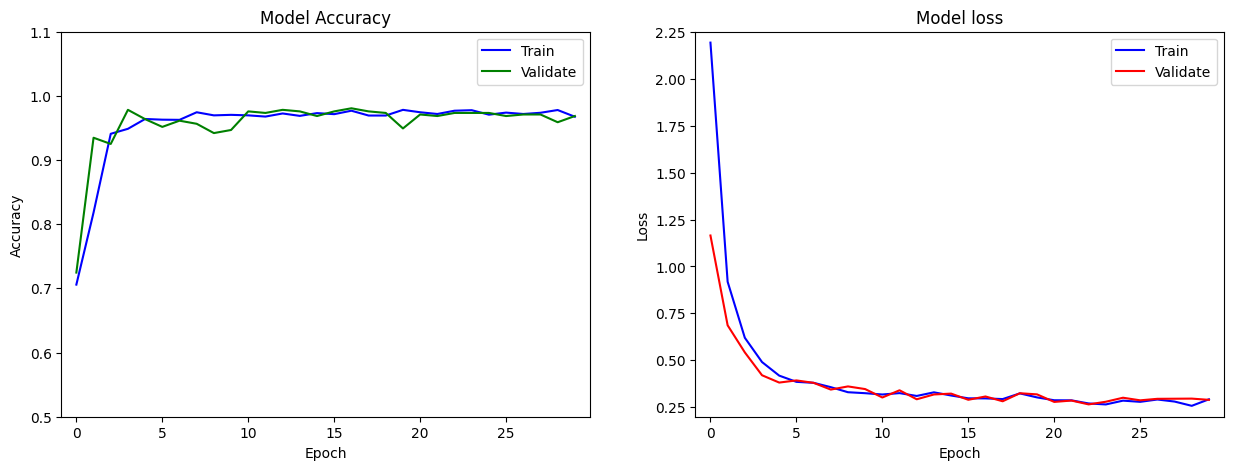

In [36]:
plot_history_nn(history3)

Тук моделът изглежда да е балансиран.